In [1]:
import numpy as np
import itertools as itr

import os as os
import sys as sys 
import pandas as pd
import warnings
import time as time
import random
from __future__ import print_function # so print doesn't show brackets

sys.path.append(os.path.join("..","Libraries","QML_lib"))
import Evo as evo
import DataBase 
import QMD
import QML
import ModelGeneration
import BayesF
import matplotlib.pyplot as plt

global paulis_list
paulis_list = {'i' : np.eye(2), 'x' : evo.sigmax(), 'y' : evo.sigmay(), 'z' : evo.sigmaz()}

warnings.filterwarnings("ignore", message='Negative weights occured', category=RuntimeWarning)

class NewQMDClass():
    #TODO: rename as ModelsDevelopmentClass when finished
    def __init__(self,
                 initial_op_list,
                 true_operator='x',
                 true_param_list = None,
                 num_particles=1000,
                 max_num_models=10, 
                 max_num_qubits=4, 
                 gaussian=True,
                 max_num_layers = 10,
                 max_num_branches = 20, 
                 use_exp_custom = True,
                 debug_directory = None,
                 qle = True # Set to False for IQLE
                ):
#    def __init__(self, initial_op_list, true_op_list, true_param_list):
        self.QLE = qle # Set to False for IQLE
        trueOp = DataBase.operator(true_operator)
        self.TrueOpName = true_operator
        self.TrueOpDim = trueOp.num_qubits
        self.InitialOpList = initial_op_list
        self.TrueOpList = trueOp.constituents_operators
        if true_param_list is not None: 
            self.TrueParamsList = true_param_list
        else:
            print("No parameters passed, randomising")
            self.TrueParamsList = [random.random() for i in self.TrueOpList] # TODO: actual true params?
        # todo set true parmams properly
        #self.TrueParamsList = [0.75 for i in self.TrueOpList] # TODO: actual true params?
        #self.TrueHam = evo.getH(self.TrueParamsList, self.TrueOpList)
        self.TrueHam = np.tensordot(self.TrueParamsList, self.TrueOpList, axes=1)
        self.MaxModNum = max_num_models #TODO: necessary?
        self.gaussian = gaussian
        self.NumModels = len(initial_op_list)
        self.NumParticles = num_particles
        self.MaxQubitNumber = max_num_qubits
        self.NumProbes = 40
        self.ProbeDict = seperable_probe_dict(max_num_qubits=self.MaxQubitNumber, num_probes=self.NumProbes)
        self.HighestQubitNumber = int(0)
        self.MaxBranchID = max_num_branches
        self.HighestBranchID = 0
        self.HighestModelID = len(initial_op_list)
        self.MaxLayerNumber = max_num_layers
        self.BranchChampions = {}
        self.LayerChampions = {}
        self.BayesFactorsByBranch ={}
        self.BranchRankings = {}
        self.BranchBayesComputed = {}
        self.InterBranchChampions = {}
        self.GlobalEpoch = 0 
        self.UseExpCustom = use_exp_custom
        self.DebugDirectory = debug_directory
        
        self.BranchBayesComputed[0] = False
#        for i in range(self.MaxBranchID+1):
#            self.BranchChampions[i] = 0
#        for i in range(self.MaxLayerNumber+1):
#            self.LayerChampions[i] = 0
        
        if self.QLE:
            print("Running QLE for true operator ", true_operator, " with parameters : ", self.TrueParamsList)
        else: 
            print("Running IQLE for true operator ", true_operator, " with parameters : ", self.TrueParamsList)
        # Initialise database and lists.
        self.initiateDB()
        
    def initiateDB(self):
        
        ## TODO: Models should be initialised with appropriate TrueOp dimension -- see getListTrueOpByDimension function
        self.db, self.legacy_db, self.model_lists = \
            DataBase.launch_db(
                true_op_name = self.TrueOpName,
                gen_list = self.InitialOpList,
                qle = self.QLE,
                true_ops = self.TrueOpList,
                true_params = self.TrueParamsList,
                num_particles = self.NumParticles,
                redimensionalise = False,
                num_probes = self.NumProbes,
                probe_dict = self.ProbeDict,
                use_exp_custom = self.UseExpCustom,
                debug_directory = self.DebugDirectory
            )
    def addModel(self, model, branchID=0):
        #self.NumModels += 1
        tryAddModel = DataBase.add_model(
            model_name = model,
            running_database = self.db,
            num_particles = self.NumParticles, 
            true_op_name = self.TrueOpName,
            model_lists = self.model_lists,
            true_ops = self.TrueOpList,
            true_params = self.TrueParamsList,
            branchID = branchID,
            num_probes = self.NumProbes,
            probe_dict = self.ProbeDict,
            use_exp_custom = self.UseExpCustom,
            debug_directory = self.DebugDirectory,
            modelID = self.NumModels,
            redimensionalise = False,
            qle = self.QLE
        )
        if tryAddModel == True: ## keep track of how many models/branches in play
            self.HighestModelID += 1 
            self.NumModels += 1
            if DataBase.get_num_qubits(model) > self.HighestQubitNumber:
                self.HighestQubitNumber = DataBase.get_num_qubits(model)
        #else: 
        #    self.NumModels-=int(1)

    def newBranch(self, model_list):
        self.HighestBranchID += 1
        branchID = self.HighestBranchID
        self.BranchBayesComputed[branchID] = False
        for model in model_list:
            self.addModel(model, branchID=branchID)
    
    def printState(self):
        print("Branch champions: \n", self.BranchChampions)
        print("InterBranch champions: \n", self.InterBranchChampions)
        print("Branch Rankings: \n", self.BranchRankings)
        #print("Layer Champions: \n", self.LayerChampions)
            
            
    def getModelInstance(self, name):
        try: 
            instance = DataBase.get_qml_instance(self.db, name)
            return instance
        except: 
            if name in list(self.legacy_db['<Name>']):
                print("Operator in legacy databse - retired. ")
            else: 
                print("Model not found.")
    def getOperatorInstance(self, name):
        try: 
            return DataBase.get_operator_instance(self.db, name)
        except:
            if name in list(self.legacy_db['<Name>']):
                print("Operator in legacy databse - retired. ")
            else: 
                print("Operator not found.")

    def getModelDBIndex(self, name):
        return DataBase.get_location(self.db, name)

    def getModelInstanceFromID(self, model_id):
        return DataBase.model_instance_from_id(self.db, model_id)    
    
    def killModel(self, name):
        if name not in list(self.db['<Name>']):
            print("Cannot remove ", name, "; not in ", list(self.db["<Name>"]))
        else:
            print("Killing model", name)
            # Add to legacy_db
            DataBase.move_to_legacy(self.db, self.legacy_db, name)
            model_instance = self.getModelInstance(name)
            operator_instance = self.getOperatorInstance(name)
            # Remove from self.db
            self.db = DataBase.remove_model(self.db, name)
            del model_instance
            del operator_instance
    
            #TODO: plot?

    def runIQLE(self, model, num_exp=50):
        model_exists=False
        if model in list(self.db['<Name>']):
            model_exists = True
        elif model in list(self.legacy_db['<Name>']):
            print("Model ", model, " previously considered and retired.")
        
        has_model_finished = self.pullField(name=model, field='Completed')
        
        if model_exists==True and has_model_finished==False : 
            model_instance = self.getModelInstance(model)
            print("\nRunning IQLE for model: ", model)
            model_instance.UpdateModel(num_exp)
            self.updateModelRecord(name=model, field='Completed', new_value=True)
            #model_instance.BayesOnModelsWithinbranches
        else: 
            print("Model ", model ,"does not exist")

    def runAllActiveModelsIQLE(self, num_exp):
        active_models = self.db.loc[self.db['Status']=='Active']['<Name>']

        for model in active_models:
            self.runIQLE(model=model, num_exp=num_exp)
        self.GlobalEpoch += num_exp
            
        
    def updateModelRecord(self, field, name=None, model_id=None, new_value=None, increment=None):
        DataBase.update_field(
            db=self.db, 
            name=name,
            model_id=model_id,
            field=field,
            new_value=new_value,
            increment=increment
        )
    def pullField(self, name, field):
        return DataBase.pull_field(self.db, name, field)

    def statusChangeBranch(self, branchID, new_status='Saturated'):
        self.db.loc[ self.db['branchID']==branchID , 'Status'] = new_status

    def statusChangeModel(self, model_name, new_status='Saturated'):
        self.db.loc[ self.db['<Name>']==model_name , 'Status'] = new_status
        
    def getListTrueOpByDimension(self):
        self.TrueOpListByDim = {}
        self.TrueParamByDim = {}
        for dim in range(1, 1+self.MaxDimension):
            new_op = ModelGeneration.identity_interact(subsystem=self.TrueOpName, num_qubits=dim, return_operator=True)
            self.TrueOpListByDim[dim] = new_op.constituents_operators
        for i in range(1, self.TrueOpDim+1):
            self.TrueParamByDim[i] = self.TrueParamsList
        for i in range(self.TrueOpDim+1, self.MaxDimension):
            self.TrueParamByDim[i] = [self.TrueParamsList[0]]

    def compareModels(self, log_comparison_high=50.0, num_times_to_use = 'all', model_a_id = None, model_b_id =None, model_a = None, model_b = None, name_a=None, name_b=None):
        # Either pass in name_a and name_b OR model_a and model_b
        if model_a is None and model_b is None:
            if model_a_id is not None and model_b_id is not None: 
                model_a = self.getModelInstanceFromID(model_a_id)
                model_b = self.getModelInstanceFromID(model_b_id)
            else: # if only names were passed 
                model_a = self.getModelInstance(name_a)
                model_b = self.getModelInstance(name_b)
        if model_a ==  model_b:
            return "Same Models"
        else: 
            log_comparison_low = 1.0/log_comparison_high
            if model_a_id is None and model_b is None:
                model_a_id = model_a.ModelID
                model_b_id = model_b.ModelID

            if num_times_to_use == 'all':
                times_a = model_a.TrackTime
            elif len(model_a.TrackTime) < num_times_to_use:
                times_a = model_a.TrackTime
            else: 
                times_a = model_a.TrackTime[num_times_to_use:]

            if num_times_to_use=='all':
                times_b = model_b.TrackTime
            elif len(model_b.TrackTime) < num_times_to_use:
                times_b = model_b.TrackTime
            else: 
                times_b = model_b.TrackTime[num_times_to_use:]
            gen_a = model_a.GenSimModel
            gen_b = model_b.GenSimModel

            times = times_a + times_b
            exps_a = get_exps(model_a, gen_a, times)
            exps_b = get_exps(model_b, gen_b, times)

            log_l_a =  get_log_likelihood(model_a, gen_a, exps_a)
            log_l_b =  get_log_likelihood(model_b, gen_b, exps_b)

            print("log likelihoods")
            print(name_a, " : ", log_l_a)
            print(name_b, " : ", log_l_b)
#            bayes_factor = np.expm1(log_l_a - log_l_b) +1 #todo: is this the right exp function?
            bayes_factor = np.exp(log_l_a - log_l_b)
            model_a.addBayesFactor(compared_with=model_b_id, bayes_factor=bayes_factor)
            model_b.addBayesFactor(compared_with=model_a_id, bayes_factor=1.0/bayes_factor)

            if bayes_factor >= log_comparison_high: 
             #   print("Point to ", model_a.Name)
                return "a"
            elif bayes_factor < log_comparison_low: 
             #   print("Point to ", model_b.Name)
                return "b"
            #else:
            #    print("No real winner")  
            # todo: Add bayes_factor with mod_id's to QML class

            
    def compareModelsWithinBranch(self, branchID):
        active_models_in_branch = DataBase.active_model_ids_by_branch_id(self.db, branchID)
        
        models_points = {}
        for model_id in active_models_in_branch:
            models_points[model_id] = 0
        
        for i in range(len(active_models_in_branch)):
            mod1 = active_models_in_branch[i]
            for j in range(i, len(active_models_in_branch)): 
                mod2 = active_models_in_branch[j]
                res = self.compareModels(model_a_id = mod1, model_b_id=mod2)
                if res == "a":
                    models_points[mod1] += 1
                elif res == "b":
                    models_points[mod2] += 1
                    # todo if more than one model has max points
                    
        max_points = max(models_points.values())
        max_points_branches = [key for key, val in models_points.items() if val==max_points]
        if len(max_points_branches) > 1: 
            # todo: recompare. Fnc: compareListOfModels (rather than branch based)
            champ_id = self.compareModelList(max_points_branches, bayes_threshold=1, models_points_dict=models_points)
        else: 
            champ_id = max(models_points, key=models_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)
        
        #todo list of ranked models by branch
        
        self.BranchChampions[int(branchID)] = champ_id
        for model_id in active_models_in_branch:
            self.updateModelRecord(model_id=model_id, field='Status', new_value='Deactivated')
        self.updateModelRecord(name=DataBase.model_name_from_id(self.db, champ_id), field='Status', new_value='Active')

        ranked_model_list = sorted_keys = sorted(models_points, key=models_points.get, reverse=True)

        if self.BranchBayesComputed[int(float(branchID))] == False: # only update self.BranchRankings the first time branch is considered
            self.BranchRankings[int(float(branchID))] = ranked_model_list
            self.BranchBayesComputed[int(float(branchID))] = True
            
        print("Champion of branch ", branchID, " is ", champ_name)
        return models_points, champ_id

    
    def compareModelList(self, model_list, bayes_threshold = 50, models_points_dict=None):
        models_points = {}
        for mod in model_list:
            models_points[mod] = 0
        
        for i in range(len(model_list)):
            mod1 = model_list[i]
            for j in range(i, len(model_list)):
                mod2 = model_list[j]
                if mod1 != mod2:
                    res = self.compareModels(model_a_id=mod1, model_b_id=mod2, log_comparison_high=bayes_threshold)
                    if res == "a":
                        models_points[mod1] += 1
                        if models_points_dict is not None: 
                            models_points_dict[mod1]+=1
                    elif res == "b":
                        models_points[mod2]+=1
                        if models_points_dict is not None: 
                            models_points_dict[mod2]+=1

        max_points = max(models_points.values())
        max_points_branches = [key for key, val in models_points.items() if val==max_points]
        if len(max_points_branches) > 1: 
            # todo: recompare. Fnc: compareListOfModels (rather than branch based)
            print("No distinct champion, recomputing bayes factors between : ", max_points_branches)
            champ_id = self.compareModelList(max_points_branches, bayes_threshold=1)
        else: 
            champ_id = max(models_points, key=models_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)

        
        return champ_id
    
    def interBranchChampion(self, branch_list=[], global_champion=False):
        all_branches = self.db['branchID'].unique()
        if global_champion == True: 
            branches = all_branches
        else: 
            branches = branch_list
        
        num_branches = len(branches)
        points_by_branches = [None] * num_branches
        champions_of_branches = [None] * num_branches

        for i in range(num_branches):
            branchID = branches[i]
            if branchID not in all_branches:
                print("branch ID : ", branchID)
                warnings.warn("branch not in database.")
                return False
            points_by_branches[i], champions_of_branches[i] = qmd.compareModelsWithinBranch(branchID)

        branch_champions_points = {}
        for c in champions_of_branches: 
            branch_champions_points[c] = 0

        for i in range(num_branches):
            mod1 = champions_of_branches[i]
            for j in range(i, num_branches):
                mod2 = champions_of_branches[j]
                if mod1!=mod2:
                    res = self.compareModels(model_a_id=mod1, model_b_id=mod2, log_comparison_high=20.0)
                    if res == "a":
                        branch_champions_points[mod1] += 1
                    elif res == "b":
                        branch_champions_points[mod2] += 1
        self.ranked_champions = sorted(branch_champions_points, reverse=True)
        
        max_points = max(branch_champions_points.values())
        max_points_branches = [key for key, val in branch_champions_points.items() if val==max_points]
        if len(max_points_branches) > 1: 
            # todo: recompare. Fnc: compareListOfModels (rather than branch based)
            print("No distinct champion, recomputing bayes factors between : ", max_points_branches)
            champ_id = self.compareModelList(max_points_branches, bayes_threshold=1, models_points_dict=branch_champions_points)
        else: 
            champ_id = max(branch_champions_points, key=branch_champions_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)
        
        branch_champ_names = [DataBase.model_name_from_id(self.db, mod_id) for mod_id in champions_of_branches]
        self.statusChangeModel(champ_name, new_status = 'Active')
        
        interBranchChampListID = len(self.InterBranchChampions)
        self.InterBranchChampions[interBranchChampListID] = [branches, champ_id]
        return champ_name, branch_champ_names
    
    def globalChampionCalculation(self):
        branches = self.db['branchID'].unique()
        
        num_branches = len(branches)
        self.points_by_branches = [None] * num_branches
        self.champions_of_branches = [None] * num_branches

        for i in range(num_branches):
            branchID = branches[i]
            self.points_by_branches[i], self.champions_of_branches[i] = qmd.compareModelsWithinBranch(branchID)

        self.champions_points = {}
        for c in self.champions_of_branches: 
            self.champions_points[c] = 0

        for i in range(num_branches):
            mod1 = self.champions_of_branches[i]
            for j in range(i, num_branches):
                mod2 = self.champions_of_branches[j]
                if mod1!=mod2:
                    res = self.compareModels(model_a_id=mod1, model_b_id=mod2, log_comparison_high=10.0)
                    if res == "a":
                        self.champions_points[mod1] += 1
                    elif res == "b":
                        self.champions_points[mod2]+=1
        self.ranked_champions = sorted(self.champions_points, reverse=True)
        champ_id = max(self.champions_points, key=self.champions_points.get)
        champ_name = DataBase.model_name_from_id(self.db, champ_id)
        print("Champion of Champions is",  champ_name)
        
        
    def spawn(self, 
              branch_list = None, 
              num_models_to_consider=1, 
              absolute_champion=False, 
              all_branches=False
             ):

        if all_branches or branch_list is None: 
            global_champion = True
            
        overall_champ, branch_champions = self.interBranchChampion(branch_list=branch_list, global_champion=global_champion)

        if absolute_champion:
            new_models = ModelGeneration.new_model_list(model_list=[overall_champ], generator='simple_ising',options=['x', 'y'])
        else: 
            new_models = ModelGeneration.new_model_list(model_list=branch_champions, generator='simple_ising', options=['x', 'y'])
        
        print("New models to add to new branch : ", new_models)
        qmd.newBranch(model_list=new_models) 
        
        #todo probailistically append model_list with suboptimal model in any of the branches in branch_list

    def runQMD(self, num_exp = 20, max_branches= None, max_num_qubits = None, max_num_models=None):
        if max_branches is None:
            max_branches = self.MaxBranchID

        if max_num_qubits is None:
            max_num_qubits = self.MaxQubitNumber
            
        if max_num_models is None: 
            max_num_models = self.MaxModNum
            
        while self.HighestQubitNumber < max_num_qubits: 
            self.runAllActiveModelsIQLE(num_exp=num_exp)
            self.spawn()
            if self.HighestBranchID > max_branches or self.NumModels > max_num_models:
                break
            
        self.runAllActiveModelsIQLE(num_exp=num_exp)
        final_winner, final_branch_winners = self.interBranchChampion(global_champion=True)
        print("Final winner = ", final_winner)

    def inspectModel(self, name):
        print("\nmodel name: ", name)
        mod = self.getModelInstance(name)
        
        print("experiments done ", mod.NumExperimentsToDate)
        print("times: ",  mod.TrackTime)
        print("final params : ", mod.FinalParams)
        print("bayes factors: ", mod.BayesFactors)
        
def get_exps(model, gen, times):

    exps = np.empty(len(times), dtype=gen.expparams_dtype)
    exps['t'] = times

    for i in range(1, len(gen.expparams_dtype)):
        col_name = 'w_'+str(i)
        exps[col_name] = model.FinalParams[i-1,0] ## TODO: should be model.NewEval[i-1]???
    return exps

def get_log_likelihood(model, gen, exps):
    import copy
    updater = copy.deepcopy(model.Updater)
    data = gen.simulate_experiment(model.SimParams, exps)[0][0]
    updater.batch_update(data, exps, resample_interval=100)

    log_likelihood = updater.log_total_likelihood
    #if log_likelihood < 10e-16:
    #    print("log likelihood = ", log_likelihood, " so replacing with ", 1e-9)
    #    log_likelihood = 10e-16
    del updater
    #print("log likelihood = ", log_likelihood)
    return log_likelihood        


def seperable_probe_dict(max_num_qubits, num_probes):
    seperable_probes = {}
    for i in range(num_probes):
        seperable_probes[i,0] = random_probe(1)
        for j in range(1, 1+max_num_qubits):
            if j==1:
                seperable_probes[i,j] = seperable_probes[i,0]
            else: 
                seperable_probes[i,j] = np.tensordot(seperable_probes[i,j-1], random_probe(1), axes=0).flatten(order='c')
            if np.linalg.norm(seperable_probes[i,j]) < 0.999999999 or np.linalg.norm(seperable_probes[i,j]) > 1.0000000000001:
                print("non-unit norm: ", np.linalg.norm(seperable_probes[i,j]))
    return seperable_probes

def random_probe(num_qubits):
    dim = 2**num_qubits
    real = np.random.rand(1,dim)
    imaginary = np.random.rand(1,dim)
    complex_vectors = np.empty([1, dim])
    complex_vectors = real +1.j*imaginary
    norm_factor = np.linalg.norm(complex_vectors)
    probe = complex_vectors/norm_factor
    return probe[0][:]





/usr/local/lib/python2.7/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/qinfer/parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [ ]:
paulis = ['x', 'y', 'z'] # will be chosen at random. or uncomment below and comment within loop to hard-set

num_exp = 50
num_part = 500
num_tests = 100

qle_list = []
iqle_list = []
true_param_list = []
qle_differences = []
iqle_differences = []

just_iqle = False

for i in range(num_tests):
    true_params = [np.random.rand()]
    true_param_list.append(true_params[0])
    true_op=np.random.choice(paulis) # to choose a random True model each time 
    # (Note: not learning between models yet; just learning paramters of true model)
    sim_op = true_op+'T'+true_op


In [ ]:
true_op='x'
sim_op = true_op+'T'+true_op

In [ ]:
sim_op

Running IQLE for true operator  x  with parameters :  [0.23827124697999702]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 3.27967384688
Final time selected > 3658422.56204
Exiting learning for Reaching Cov. Norm. Thrshold of 9.6547769779e-14
 at Iteration Number 494
Final Parameters mean and stdev:[  2.38271283e-01   3.31980400e-07]
Killing model x
Model instance  x  moved to legacy db
Running QLE for true operator  x  with parameters :  [0.23827124697999702]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 2.97559023022
Final time selected > 272947.223322
Final Parameters mean and stdev:[ -2.38269987e-01   6.49616323e-06]
Killing model x
Model instance  x  moved to legacy db
Running IQLE for true operator  z  with parameters :  [0.6795529724210282]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.25516943347). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.89882085697). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.95845591367). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 4185807.18491
Exiting learning for Reaching Cov. Norm. Thrshold of 9.37028232784e-14
 at Iteration Number 335
Final Parameters mean and stdev:[  1.06383612e+00   8.97513795e-07]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true operator  y  with parameters :  [0.38551525827379574]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.07935587214
Final time selected > 3100040.33849
Exiting learning for Reaching Cov. Norm. Thrshold of 3.62765373296e-14
 at Iteration Number 183
Final Parameters mean and stdev:[  3.85515532e-01   1.90368164e-07]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.14262389054272895]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.54694748777


/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (3.81310884911). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (5.95572428064). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 4584623.35609
Exiting learning for Reaching Cov. Norm. Thrshold of 7.22512327744e-14
 at Iteration Number 406
Final Parameters mean and stdev:[  1.65810095e-01   2.68768088e-07]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true operator  y  with parameters :  [0.14262389054272895]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 2.56543829693
Final time selected > 3681043.24164
Final Parameters mean and stdev:[ -1.42619833e-01   8.61743903e-06]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.9914691232679623]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 2.75550725298
Final time selected > 2698321.05481
Exiting learning for Reaching Cov. Norm. Thrshold of 9.92539384015e-14
 at Iteration Number 155
Final Parameters mean and stdev:[  9.9

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.88271463617). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 3788434.30294
Exiting learning for Reaching Cov. Norm. Thrshold of 7.54951656745e-14
 at Iteration Number 438
Final Parameters mean and stdev:[  1.01182509e+00   3.57127804e-07]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  x  with parameters :  [0.47972666284035015]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 1.81852496832


/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.87874392163). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 4299003.11488
Exiting learning for Reaching Num. Prec. -  Iteration Number 365
Final Parameters mean and stdev:[  4.79726319e-01   1.13735335e-06]
Killing model x
Model instance  x  moved to legacy db
Running QLE for true operator  x  with parameters :  [0.47972666284035015]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 0.839937310241
Final time selected > 10.9084428152
Final Parameters mean and stdev:[-0.36431776  0.30465922]
Killing model x
Model instance  x  moved to legacy db
Running IQLE for true operator  z  with parameters :  [0.967924119441894]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 0.373808359749
Final time selected > 1677249.76016
Exiting learning for Reaching Cov. Norm. Thrshold of 7.46069872548e-14
 at Iteration Number 235
Final Parameters mean and stdev:[  9.67924215e-01   3.49607585e-07]
Killing mo

Final time selected > 4292186.47963
Exiting learning for Reaching Cov. Norm. Thrshold of 9.91845494624e-14
 at Iteration Number 469
Final Parameters mean and stdev:[ -2.43616527e-01   6.47578770e-07]
Killing model x
Model instance  x  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.23306304924596466]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.06105710307
Final time selected > 1100678.00479
Exiting learning for Reaching Cov. Norm. Thrshold of 8.41340885849e-14
 at Iteration Number 183
Final Parameters mean and stdev:[  2.33062886e-01   2.89985311e-07]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true operator  y  with parameters :  [0.23306304924596466]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.65593573838
Final time selected > 2647073.96571
Exiting learning for Reaching Cov. No

Final time selected > 2019857.01881
Exiting learning for Reaching Cov. Norm. Thrshold of 3.76532572482e-14
 at Iteration Number 174
Final Parameters mean and stdev:[  2.37988962e-02   6.63292892e-07]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true operator  y  with parameters :  [0.023799191479018655]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 0.371796909925
Final time selected > 479008.946578
Exiting learning for Reaching Num. Prec. -  Iteration Number 362
Final Parameters mean and stdev:[  2.37989245e-02   7.80625227e-07]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  x  with parameters :  [0.44139183132534154]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 0.517331515062
Final time selected > 1431665.17684
Exiting learning for Reaching Num. Prec. -  Iteration Number 308


/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (6.74192472676). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 4452862.51679
Exiting learning for Reaching Cov. Norm. Thrshold of 9.87057657831e-14
 at Iteration Number 243
Final Parameters mean and stdev:[  2.35363539e-01   5.17416590e-07]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  z  with parameters :  [0.3293900200857055]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 1.09039215552
Final time selected > 1760377.49771
Exiting learning for Reaching Cov. Norm. Thrshold of 7.03465063978e-14
 at Iteration Number 123
Final Parameters mean and stdev:[  3.29390086e-01   2.65240992e-07]
Killing model z
Model instance  z  moved to legacy db
Running QLE for true operator  z  with parameters :  [0.3293900200857055]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 0.941914450088
Final time selected > 2334300.90654
Final Parameters mean and stdev:[ -3.2

Final time selected > 901547.100121
Final Parameters mean and stdev:[  3.89489323e-01   3.54176996e-06]
Killing model x
Model instance  x  moved to legacy db
Running QLE for true operator  x  with parameters :  [0.38605970659506794]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 0.453502505944
Final time selected > 1.1291055758
Final Parameters mean and stdev:[ 0.24977049  0.274165  ]
Killing model x
Model instance  x  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.7980400000249969]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 0.416403661071
Final time selected > 917182.543872
Exiting learning for Reaching Cov. Norm. Thrshold of 7.40518757425e-14
 at Iteration Number 232
Final Parameters mean and stdev:[  8.07029244e-01   4.97622781e-07]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true 

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (3.61240212203). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.43466025556). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 683992.806244
Final Parameters mean and stdev:[  9.07740307e-01   4.43653922e-07]
Killing model x
Model instance  x  moved to legacy db
Running QLE for true operator  x  with parameters :  [0.9154312815248167]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 1.19022915834
Final time selected > 2849494.59318
Exiting learning for Reaching Cov. Norm. Thrshold of 9.03721542045e-14
 at Iteration Number 390
Final Parameters mean and stdev:[  9.15431395e-01   3.36761641e-07]
Killing model x
Model instance  x  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.4308438106445145]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.48039751321
Final time selected > 2517056.83171
Exiting learning for Reaching Cov. Norm. Thrshold of 3.5887959271e-14
 at Iteration Number 160
Final Parameters mean and stdev:[  4.308

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.66602596849). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 1016211.97916
Exiting learning for Reaching Cov. Norm. Thrshold of 9.34807786734e-14
 at Iteration Number 234
Final Parameters mean and stdev:[  6.05031777e-01   4.57421715e-07]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true operator  y  with parameters :  [0.6050319117538382]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 7.29483065165
Final time selected > 2072352.42463
Exiting learning for Reaching Cov. Norm. Thrshold of 5.12923037377e-14
 at Iteration Number 283
Final Parameters mean and stdev:[  6.05031922e-01   4.32724598e-07]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  z  with parameters :  [0.7485580285791752]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 12.6661714084
Final time selected > 858254.295305
Exiting learning for Reaching Cov. Norm

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.87369564062). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 2092356.83064
Exiting learning for Reaching Num. Prec. -  Iteration Number 159
Final Parameters mean and stdev:[  2.01069199e-01   5.86316304e-07]
Killing model z
Model instance  z  moved to legacy db
Running QLE for true operator  z  with parameters :  [0.20106913385644853]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 1.28191527866
Final time selected > 1819540.29876
Exiting learning for Reaching Cov. Norm. Thrshold of 5.7551186039e-14
 at Iteration Number 241
Final Parameters mean and stdev:[  2.01069191e-01   3.50527168e-07]
Killing model z
Model instance  z  moved to legacy db
Running IQLE for true operator  z  with parameters :  [0.949444585701066]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 0.904770812554
Final time selected > 1116669.59351
Exiting learning for Reaching Cov. Norm. Thrshold of 9.65894031424e-14

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (5.02393508815). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 1941872.28388
Exiting learning for Reaching Cov. Norm. Thrshold of 7.22755189031e-14
 at Iteration Number 257
Final Parameters mean and stdev:[  9.02022210e-01   3.31629025e-07]
Killing model y
Model instance  y  moved to legacy db
Running QLE for true operator  y  with parameters :  [0.9070067262355449]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.64901516668
Final time selected > 1582392.69425
Exiting learning for Reaching Cov. Norm. Thrshold of 7.4162898045e-14
 at Iteration Number 174
Final Parameters mean and stdev:[  9.07006928e-01   2.71720761e-07]
Killing model y
Model instance  y  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.47250888233193045]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 14.3865352617
Final time selected > 2595640.93901
Exiting learning for Reaching Cov. Norm

Final time selected > 1276964.26077
Exiting learning for Reaching Num. Prec. -  Iteration Number 189
Final Parameters mean and stdev:[  9.56340841e-01   8.41154328e-07]
Killing model z
Model instance  z  moved to legacy db
Running QLE for true operator  z  with parameters :  [0.9563408778744836]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 0.475860941968
Final time selected > 655802.104298
Exiting learning for Reaching Cov. Norm. Thrshold of 9.37028232784e-14
 at Iteration Number 216
Final Parameters mean and stdev:[  9.56339774e-01   3.68193874e-07]
Killing model z
Model instance  z  moved to legacy db
Running IQLE for true operator  x  with parameters :  [0.4667713154320472]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 0.496630743145
Final time selected > 965462.522522
Exiting learning for Reaching Cov. Norm. Thrshold of 7.7049477909e-1

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (7.6054549042). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 1560545.73967
Exiting learning for Reaching Cov. Norm. Thrshold of 7.06101843662e-14
 at Iteration Number 340
Final Parameters mean and stdev:[  1.00432215e+00   3.47221391e-07]
Killing model z
Model instance  z  moved to legacy db
Running IQLE for true operator  x  with parameters :  [0.1824523727876376]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 3.53473482405
Final time selected > 1178935.4087
Exiting learning for Reaching Cov. Norm. Thrshold of 7.88119569606e-14
 at Iteration Number 259
Final Parameters mean and stdev:[  1.82450298e-01   2.80723612e-07]
Killing model x
Model instance  x  moved to legacy db
Running QLE for true operator  x  with parameters :  [0.1824523727876376]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 0.405675917491
Final time selected > 1906.65730559
Final Parameters mean and stdev:[ 0.182

Final time selected > 3583270.52076
Exiting learning for Reaching Cov. Norm. Thrshold of 8.41549052666e-14
 at Iteration Number 173
Final Parameters mean and stdev:[  9.51930280e-01   4.82042113e-07]
Killing model z
Model instance  z  moved to legacy db
Running IQLE for true operator  x  with parameters :  [0.3839790292678217]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 0.663306505734
Final time selected > 11558436.1727
Exiting learning for Reaching Cov. Norm. Thrshold of 7.22338855397e-14
 at Iteration Number 476
Final Parameters mean and stdev:[  2.60329928e-01   2.68841819e-07]
Killing model x
Model instance  x  moved to legacy db
Running QLE for true operator  x  with parameters :  [0.3839790292678217]
Model  x  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  x
Initial time selected > 10.5706138861
Final time selected > 146513.153478
Final Parameters mean and stdev:[ -3.8

/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.26595757512). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/usr/local/lib/python2.7/dist-packages/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (5.66036325365). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning


Final time selected > 1381466.97681
Final Parameters mean and stdev:[  5.28053078e-01   1.17472748e-06]
Killing model z
Model instance  z  moved to legacy db
Running QLE for true operator  z  with parameters :  [0.427193977731987]
Model  z  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  z
Initial time selected > 4.73160293699
Final time selected > 1557135.24626
Exiting learning for Reaching Cov. Norm. Thrshold of 4.60430304994e-14
 at Iteration Number 488
Final Parameters mean and stdev:[  9.57478221e-02   3.67886411e-07]
Killing model z
Model instance  z  moved to legacy db
Running IQLE for true operator  y  with parameters :  [0.10943515264166237]
Model  y  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  y
Initial time selected > 1.01156918284
Final time selected > 1889174.56751
Exiting learning for Reaching Cov. Norm. Thrshold of 4.19820428421e-14
 at Iteration Number 191
Final Parameters mean and stdev:[  1.09

true: 0.936178860571 	 QLE:  0.936178100375  		 IQLE : 0.93620001018
Differences  : 	 	 QLE  7.60196379512e-07 		 IQLE :  2.11496084445e-05


true: 0.254793511921 	 QLE:  0.254793559681  		 IQLE : 0.254793339425
Differences  : 	 	 QLE  4.77601825866e-08 		 IQLE :  1.72495982331e-07


true: 0.631016347655 	 QLE:  0.631017985419  		 IQLE : 0.631034638842
Differences  : 	 	 QLE  1.63776386075e-06 		 IQLE :  1.82911867964e-05


true: 0.646608129209 	 QLE:  0.646608164258  		 IQLE : 0.646607469961
Differences  : 	 	 QLE  3.50497010304e-08 		 IQLE :  6.59247241686e-07


true: 0.956340877874 	 QLE:  0.956339773545  		 IQLE : 0.9563408409
Differences  : 	 	 QLE  1.10432919265e-06 		 IQLE :  3.69741612882e-08


true: 0.466771315432 	 QLE:  0.427874679537  		 IQLE : 0.466771442316
Differences  : 	 	 QLE  0.038896635895 		 IQLE :  1.26884382445e-07


true: 0.405836267997 	 QLE:  1.00432215013  		 IQLE : 0.405836121967
Differences  : 	 	 QLE  0.598485882132 		 IQLE :  1.46030189829e-07


true: 0.1

ValueError: x and y must have same first dimension, but have shapes (5,) and (494,)

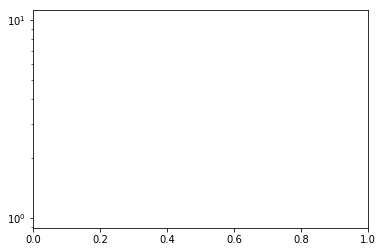

In [60]:
# This cell runs tests on IQLE and QLE and plots the resulting errors and quadratic losses

import matplotlib.pyplot as plt

paulis = ['x', 'y', 'z'] # will be chosen at random. or uncomment below and comment within loop to hard-set

num_exp = 500
num_part = 100
num_tests = 100

qle_list = []
iqle_list = []
true_param_list = []
qle_differences = []
iqle_differences = []
qle_qlosses = []
qle_final_qloss =[]
iqle_qlosses =[]
iqle_final_qloss =[]

just_iqle = False

for i in range(num_tests):
    true_params = [np.random.rand()]
    true_param_list.append(true_params[0])
    true_op=np.random.choice(paulis) # to choose a random True model each time 
    # (Note: not learning between models yet; just learning paramters of true model)

    qle_values = [False]
    if just_iqle is not True:
        qle_values.append(True)
    
    for qle in qle_values:
        qmd = NewQMDClass(initial_op_list=[true_op], true_operator=true_op, true_param_list=true_params, num_particles=num_part, qle=qle)
        qmd.runAllActiveModelsIQLE(num_exp=num_exp)
        
        mod = qmd.getModelInstance(true_op)
        if qle is True:
            qle_list.append(mod.FinalParams[0][0])
            qle_qlosses.append(mod.QLosses)
            qle_final_qloss.append(mod.QLosses[-1])
        else: 
            iqle_list.append(mod.FinalParams[0][0])
            iqle_qlosses.append(mod.QLosses)
            iqle_final_qloss.append(mod.QLosses[-1])
            
        qmd.killModel(true_op)
        del qmd
    
print("\n\n\n \t\t\tResults \n\n\n")
for i in range(num_tests):
    if just_iqle:
        print("true:", true_param_list[i], " \t\t IQLE :", iqle_list[i])
        iqle_diff =np.abs(true_param_list[i]-iqle_list[i])
        print("Differences  : \t\t\t IQLE : ", np.abs(true_param_list[i]-iqle_list[i]) )
        iqle_differences.append(iqle_diff)
    
    else:
        print("true:", true_param_list[i], "\t QLE: ", qle_list[i], " \t\t IQLE :", iqle_list[i])
        qle_diff =np.abs(true_param_list[i]-qle_list[i])
        iqle_diff =np.abs(true_param_list[i]-iqle_list[i])
        print("Differences  : \t \t QLE ", qle_diff , "\t\t IQLE : ", iqle_diff )
        iqle_differences.append(iqle_diff)
        qle_differences.append(qle_diff)
    print("\n")
    qle_list
   
%matplotlib inline
plt.clf()
plt.hist(iqle_differences, normed=False, bins=30)
plt.ylabel('Count of IQLE runs');
plt.xlabel('Error');
plt.title('Count of IQLE runs by error margin (single parameter, '+str(num_tests)+' runs)');
plt.savefig('test_plots/iqle_errors_histogram_'+str(num_tests)+'_runs.png')
plt.plot()    


%matplotlib inline
plt.clf()
plt.hist(iqle_differences, normed=False, bins=30)
plt.ylabel('Count of IQLE runs');
plt.xlabel('Error');
plt.title('Count of IQLE runs by final Quadratic Loss (single parameter, '+str(num_tests)+' runs)');
plt.savefig('test_plots/iqle_final_quad_loss_histogram_'+str(num_tests)+'_runs.png')
plt.plot()    
    

%matplotlib inline
plt.clf()
for i in range(num_tests):
    plt.semilogy( range(1, 1+num_exps), iqle_qlosses[i])
plt.xlabel('Experiment Number');
plt.ylabel('Quadratic Loss');
plt.title('IQLE Quadratic Loss per experiment (single parameter, '+str(num_tests)+' runs)');
plt.savefig('test_plots/iqle_scatter_'+str(num_tests)+'_runs.png')
plt.plot()    
    

if just_iqle is not True:    


    %matplotlib inline
    plt.clf()
    plt.hist(qle_differences, normed=False, bins=30)
    plt.ylabel('Count of QLE runs');
    plt.xlabel('Error');
    plt.title('Count of QLE runs by error margin (single parameter, '+str(num_tests)+' runs)');
    plt.savefig('test_plots/qle_errors_histogram_'+str(num_tests)+'_runs.png')
    plt.plot()    



    %matplotlib inline
    plt.clf()
    plt.hist(qle_final_qloss, normed=False, bins=30)
    plt.ylabel('Count of QLE runs');
    plt.xlabel('Error');
    plt.title('Count of QLE runs by final Quadratic Loss (single parameter, '+str(num_tests)+' runs)');
    plt.savefig('test_plots/qle_final_quad_loss_histogram_'+str(num_tests)+'_runs.png')
    plt.plot()    

    num_exps = len(iqle_qlosses[0])
    num_tests= len(iqle_qlosses)



    %matplotlib inline
    plt.clf()
    for i in range(num_tests):
        plt.semilogy( range(1,1+num_exps), qle_qlosses[i])
    plt.xlabel('Experiment Number');
    plt.ylabel('Quadratic Loss');
    plt.title('QLE Quadratic Loss per experiment (single parameter, '+str(num_tests)+' runs)');
    plt.savefig('test_plots/qle_scatter_'+str(num_tests)+'_runs.png')
    plt.plot()    




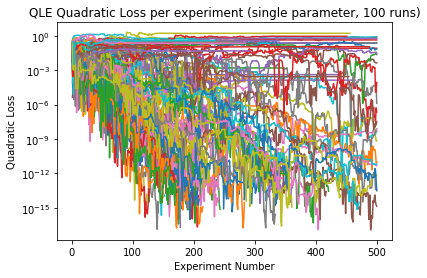

In [108]:

%matplotlib inline
plt.clf()
plt.hist(iqle_differences, normed=False, bins=30)
plt.ylabel('Count of IQLE runs');
plt.xlabel('Error');
plt.title('Count of IQLE runs by error margin (single parameter, '+str(num_tests)+' runs)');
plt.savefig('test_plots/iqle_errors_histogram_'+str(num_tests)+'_runs.png')
plt.plot()    


%matplotlib inline
plt.clf()
plt.hist(iqle_final_qloss, normed=False, bins=30)
plt.ylabel('Count of IQLE runs');
plt.xlabel('Error');
plt.title('Count of IQLE runs by final Quadratic Loss (single parameter, '+str(num_tests)+' runs)');
plt.savefig('test_plots/iqle_final_quad_loss_histogram_'+str(num_tests)+'_runs.png')
plt.plot()    
    

%matplotlib inline
plt.clf()
for i in range(num_tests):
    plt.semilogy( range(1, 1+len(iqle_qlosses[i])), iqle_qlosses[i])
plt.xlabel('Experiment Number');
plt.ylabel('Quadratic Loss');
plt.title('IQLE Quadratic Loss per experiment (single parameter, '+str(num_tests)+' runs)');
plt.savefig('test_plots/iqle_scatter_'+str(num_tests)+'_runs.png')
plt.plot()    
    

if just_iqle is not True:    


    %matplotlib inline
    plt.clf()
    plt.hist(qle_differences, normed=False, bins=30)
    plt.ylabel('Count of QLE runs');
    plt.xlabel('Error');
    plt.title('Count of QLE runs by error margin (single parameter, '+str(num_tests)+' runs)');
    plt.savefig('test_plots/qle_errors_histogram_'+str(num_tests)+'_runs.png')
    plt.plot()    



    %matplotlib inline
    plt.clf()
    plt.hist(qle_final_qloss, normed=False, bins=30)
    plt.ylabel('Count of QLE runs');
    plt.xlabel('Error');
    plt.title('Count of QLE runs by final Quadratic Loss (single parameter, '+str(num_tests)+' runs)');
    plt.savefig('test_plots/qle_final_quad_loss_histogram_'+str(num_tests)+'_runs.png')
    plt.plot()    

    num_exps = len(iqle_qlosses[0])
    num_tests= len(iqle_qlosses)



    %matplotlib inline
    plt.clf()
    for i in range(num_tests):
        plt.semilogy( range(1,1+len(qle_qlosses[i])), qle_qlosses[i])
    plt.xlabel('Experiment Number');
    plt.ylabel('Quadratic Loss');
    plt.title('QLE Quadratic Loss per experiment (single parameter, '+str(num_tests)+' runs)');
    plt.savefig('test_plots/qle_scatter_'+str(num_tests)+'_runs.png')
    plt.plot()    




In [125]:
iqle_qlosses
iqle_final_qloss
iqle_differences
qle_qlosses
qle_final_qloss
qle_differences

[3.5531470654603936e-08,
 4.2214852946642623e-08,
 0.6783208665464886,
 0.023186204287826306,
 2.9085619768220994e-07,
 3.4375897783878173e-07,
 9.52259804343214e-08,
 4.7822299045763295e-07,
 3.1338751127485409e-07,
 2.0857788976536007e-07,
 1.3121454356390672e-07,
 1.5716624590655925e-07,
 1.0265762717676097e-07,
 2.4901706957569658e-07,
 1.0394948488090527e-07,
 1.6320106552281111e-07,
 4.3954707262816584e-07,
 5.2220806640024264e-07,
 2.1190057630793291e-07,
 1.3160775050313767e-07,
 6.2093055419598642e-08,
 7.8428482430670243e-08,
 4.4183074088266494e-08,
 8.6094270101977344e-07,
 2.9529987894544307e-07,
 3.6629802357968089e-08,
 3.5891760286066443e-08,
 2.0686392154800615e-07,
 2.958133404895591e-09,
 4.8096165772282262e-08,
 4.9872326757238739e-07,
 1.1926897489772381e-07,
 1.8856498934516353e-07,
 6.5456178310885349e-08,
 4.886978355322924e-08,
 5.9402696039878577e-08,
 9.2873476020827184e-08,
 4.237856112698779e-06,
 0.012405024188414916,
 9.3052895944190084e-09,
 4.8679795494

In [135]:
this_file = open( 'test_plots/qle_qlosses.txt', 'w')
for item in qle_qlosses:
    this_file.write("%s\n" % item)

In [14]:
true_op = 'x'
true_params=[0.43]
num_exp = 10
num_part = 50
generators = ['x', 'y']
qmd = NewQMDClass(initial_op_list=['xTx'], true_operator='xTx', true_param_list=true_params, num_particles=num_part, qle=False)
qmd.runAllActiveModelsIQLE(num_exp=num_exp)

#true_models = ['x', 'y', 'z']

Running IQLE for true operator  xTx  with parameters :  [0.43]
Model  xTx  not previously considered -- adding.
Initialization Ready

Running IQLE for model:  xTx
Initial time selected > 1.3307618298
Final time selected > 5.78934067044
Final Parameters mean and stdev:[-0.0236186   0.39145818]


In [112]:
def seperable_probe_dict(max_num_qubits, num_probes):
    seperable_probes = {}
    for i in range(num_probes):
        seperable_probes[i,0] = random_probe(1)
        for j in range(1, 1+max_num_qubits):
            if j==1:
                seperable_probes[i,j] = seperable_probes[i,0]
            else: 
                new_probe = random_probe(1)
                print("current probe : \n", seperable_probes[i,j-1])
                print("tensor with : \n", new_probe )
                seperable_probes[i,j] = np.tensordot(seperable_probes[i,j-1], new_probe, axes=0).flatten(order='c')
                print("giving :\n", seperable_probes[i,j])
            if np.linalg.norm(seperable_probes[i,j]) < 0.999999999 or np.linalg.norm(seperable_probes[i,j]) > 1.0000000000001:
                print("non-unit norm: ", np.linalg.norm(seperable_probes[i,j]))
    return seperable_probes


In [119]:
a = 0.66951543+0.22815686j
b = 0.29801701+0.00188026j
print(a*b)

(0.19909799238+0.0692534883106j)


In [114]:
a = seperable_probe_dict(3,4)


current probe : 
 [ 0.52635877+0.47184742j  0.66951543+0.22815686j]
tensor with : 
 [ 0.18720754+0.93602119j  0.29801701+0.00188026j]
giving :
 [-0.34312085+0.58101635j  0.15597667+0.14160825j -0.08822131+0.66939331j
  0.19909800+0.06925348j]
current probe : 
 [-0.34312085+0.58101635j  0.15597667+0.14160825j -0.08822131+0.66939331j
  0.19909800+0.06925348j]
tensor with : 
 [ 0.50653023+0.72176999j  0.33356424+0.3334818j ]
giving :
 [-0.59316125+0.04664801j -0.30821123+0.07938172j -0.02320168+0.18430814j
  0.00480447+0.09925083j -0.52783476+0.27539245j -0.25265796+0.19386547j
  0.05086407+0.17878194j  0.04331720+0.08949604j]
current probe : 
 [ 0.51173730+0.49103222j  0.45045506+0.54231221j]
tensor with : 
 [ 0.27306646+0.91222957j  0.05388054+0.30061406j]
giving :
 [-0.30819582+0.60090632j -0.12003851+0.18029251j -0.37170907+0.5590057j
 -0.13875591+0.1646332j ]
current probe : 
 [-0.30819582+0.60090632j -0.12003851+0.18029251j -0.37170907+0.5590057j
 -0.13875591+0.1646332j ]
tensor wit